In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
data = pd.read_csv("../data/raw/fama_french_factors.csv", parse_dates=[0])
data.rename(columns={
    "Mkt-RF": "MKT_RF",
    "SMB": "SMB",
    "HML": "HML",
    "RMW": "RMW",
    "CMA": "CMA",
    "RF": "RF"
}, inplace=True)
data.set_index('date', inplace=True)
data.head()

,MKT_RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-01,-0.0067,0.0000,-0.0034,-0.0001,0.0016,0.0001
1963-07-02,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0001
1963-07-03,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0001
1963-07-05,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0001
1963-07-08,-0.0063,0.0004,-0.0018,-0.0029,0.0014,0.0001


In [24]:
data_monthly = data.resample('ME').apply(lambda x: (1 + x).prod() - 1)
print(f"Original daily rows: {len(data)}")
print(f"New monthly rows: {len(data_monthly)}")
data_monthly.head()

Original daily rows: 15690
New monthly rows: 748


,MKT_RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-31,-0.004027,-0.004712,-0.008305,0.006493,-0.011779,0.002202
1963-08-31,0.050592,-0.007507,0.016490,0.003688,-0.003525,0.002202
1963-09-30,-0.015827,-0.004544,0.000067,-0.007802,0.001667,0.002002
1963-10-31,0.025102,-0.013107,-0.000324,0.027383,-0.021471,0.002303
1963-11-30,-0.008474,-0.009033,0.018088,-0.004348,0.022234,0.003606


In [41]:
prices = pd.read_csv("../data/raw/prices_raw.csv", parse_dates=[0], index_col=0)

stock_returns_monthly = prices.resample('ME').last().pct_change().dropna()

final_df = stock_returns_monthly.join(data_monthly, how='inner')

final_df.index.name = 'date' 
final_df_reset = final_df.reset_index()

factor_cols = list(data_monthly.columns)
final_df_melted = final_df_reset.melt(
    id_vars=['date'] + factor_cols, 
    var_name='Ticker', 
    value_name='Return'
)

final_df_melted['Excess_Return'] = final_df_melted['Return'] - final_df_melted['RF']

final_df_melted['Momentum_1M'] = final_df_melted['Return']

final_df_melted = final_df_melted.sort_values(['Ticker', 'date'])
final_df_melted['Next_Month_Return'] = final_df_melted.groupby('Ticker')['Excess_Return'].shift(-1)
final_df = final_df_melted.dropna(subset=['Next_Month_Return'])

print(f"Final Dataset Ready! Total Rows: {len(final_df)}")
final_df.head()

Final Dataset Ready! Total Rows: 3290


,date,MKT_RF,SMB,HML,RMW,CMA,RF,Ticker,Return,Excess_Return,Momentum_1M,Next_Month_Return
0,2019-02-28,0.034291,0.017248,-0.025807,0.000938,-0.014958,0.001902,AAPL,0.044776,0.042875,0.044776,0.094924
1,2019-03-31,0.010810,-0.034384,-0.041612,0.008226,-0.009112,0.002102,AAPL,0.097026,0.094924,0.097026,0.054334
2,2019-04-30,0.039545,-0.011169,0.020522,0.015536,-0.021350,0.002102,AAPL,0.056436,0.054334,0.056436,-0.126415
3,2019-05-31,-0.069063,-0.016595,-0.026942,-0.005545,0.018272,0.002202,AAPL,-0.124213,-0.126415,-0.124213,0.128517
4,2019-06-30,0.069085,0.003494,-0.006747,0.008224,-0.004484,0.002002,AAPL,0.130519,0.128517,0.130519,0.074192


Training on data before: 2022-08-31 00:00:00


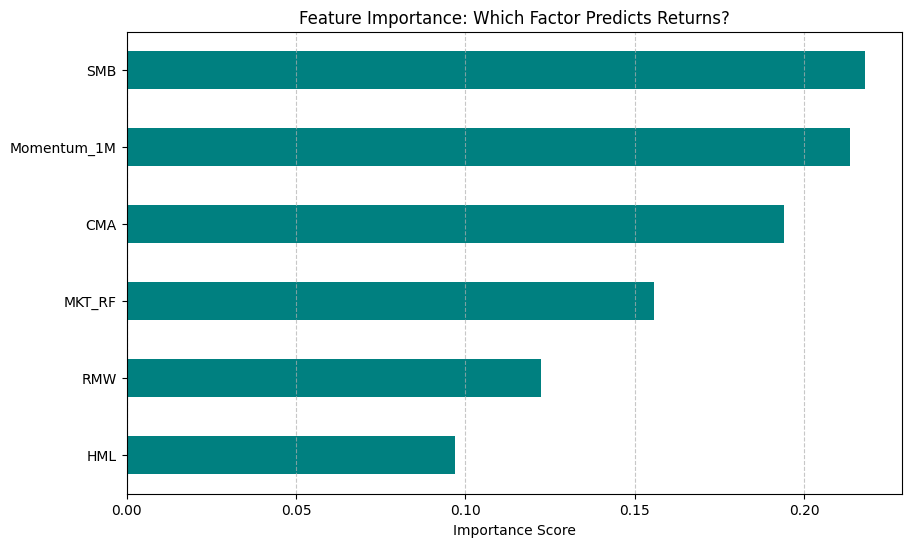

In [47]:
X = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'Momentum_1M']
y = 'Next_Month_Return'

# Time Series Split
cutoff_index = int(len(final_df) * 0.8)
cutoff_date = final_df.iloc[cutoff_index]['date']
print(f"Training on data before: {cutoff_date}")

train_df = final_df[final_df['date'] < cutoff_date]
test_df = final_df[final_df['date'] >= cutoff_date]

X_train = train_df[X]
y_train = train_df[y]
X_test = test_df[X]
y_test = test_df[y]


rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

importances = pd.Series(rf_model.feature_importances_, index=X).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title('Feature Importance: Which Factor Predicts Returns?')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

test_predictions = rf_model.predict(X_test)

mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R-squared (R²):                 {r2:.4f}")

Root Mean Squared Error (RMSE): 0.0942
Mean Absolute Error (MAE):      0.0712
R-squared (R²):                 -0.1592


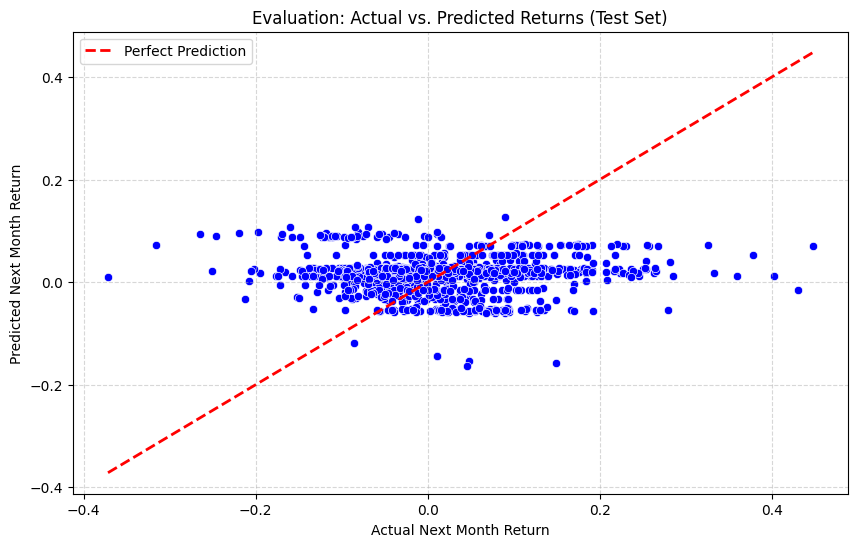

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=test_predictions, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Next Month Return')
plt.ylabel('Predicted Next Month Return')
plt.title('Evaluation: Actual vs. Predicted Returns (Test Set)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

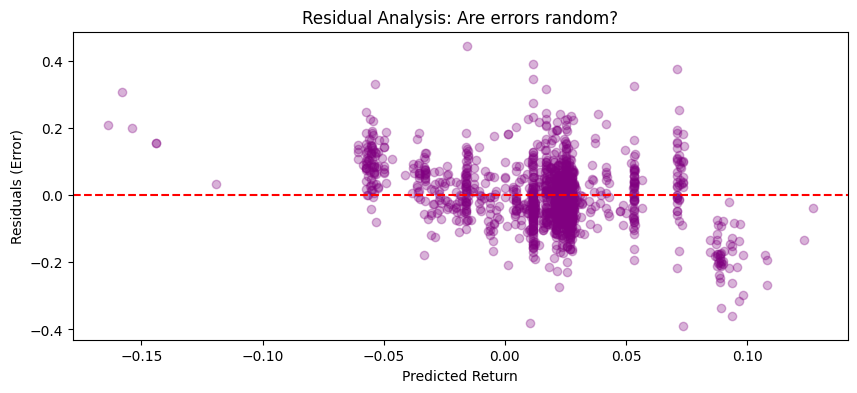

In [63]:
residuals = y_test - test_predictions
plt.figure(figsize=(10, 4))
plt.scatter(test_predictions, residuals, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Return')
plt.ylabel('Residuals (Error)')
plt.title('Residual Analysis: Are errors random?')
plt.show()

--- Model Ranking Performance ---
Mean Information Coefficient (IC): 0.0343
IC Consistency (Std Dev):          0.1551
Annualized IR (approx):            0.7661


C:\Users\mshri\AppData\Local\Temp\ipykernel_12420\4126873486.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic_series = results.groupby('date').apply(get_ic)


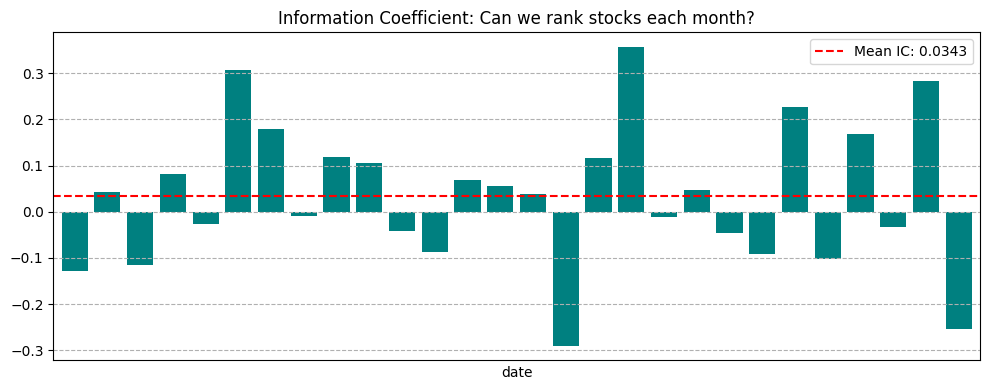

In [69]:
# Chat-GPT Assistance with ReEvaluating Ranking Performance


from scipy.stats import spearmanr

# 1. Make Predictions
# We predict on X_test (the features), but we need the Dates from test_df
test_predictions = rf_model.predict(X_test)

# 2. Create a Results DataFrame
# We explicitly pull 'date' and 'Ticker' from test_df to ensure we group correctly
results = pd.DataFrame({
    'date': test_df['date'],
    'Ticker': test_df['Ticker'],
    'Actual': y_test,
    'Predicted': test_predictions
})

# 3. Calculate Rank Correlation (IC) per Month
def get_ic(group):
    # We need at least 2 stocks to calculate correlation
    if len(group) < 2:
        return np.nan
    return spearmanr(group['Actual'], group['Predicted'])[0]

ic_series = results.groupby('date').apply(get_ic)

# 4. Results
mean_ic = ic_series.mean()
ic_std = ic_series.std()
annualized_ic = mean_ic / ic_std * np.sqrt(12) # Information Ratio approximation

print(f"--- Model Ranking Performance ---")
print(f"Mean Information Coefficient (IC): {mean_ic:.4f}")
print(f"IC Consistency (Std Dev):          {ic_std:.4f}")
print(f"Annualized IR (approx):            {annualized_ic:.4f}")

# 5. Plot
plt.figure(figsize=(10, 4))
ic_series.plot(kind='bar', color='teal', width=0.8)
plt.axhline(mean_ic, color='red', linestyle='--', label=f'Mean IC: {mean_ic:.4f}')
plt.title('Information Coefficient: Can we rank stocks each month?')
plt.legend()
plt.xticks([]) 
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [70]:
ranked_stocks = pd.DataFrame({'date': test_df['date'],'Ticker': test_df['Ticker'],'Predicted_Return': test_predictions, 'Actual_Return': y_test})

ranked_stocks['Rank'] = ranked_stocks.groupby('date')['Predicted_Return'].rank(ascending=False)
ranked_stocks = ranked_stocks.sort_values(['date', 'Rank'])

last_month = ranked_stocks['date'].max()
top_picks = ranked_stocks[(ranked_stocks['date'] == last_month) & (ranked_stocks['Rank'] <= 5)]

print(f"--- Top 5 Recommended Stocks for {last_month.date()} ---")
#Based on historical data capped at 2024
styled_picks = top_picks[['Rank', 'Ticker', 'Predicted_Return', 'Actual_Return']].style.format({
    'Predicted_Return': '{:.2%}',
    'Actual_Return': '{:.2%}'
}).background_gradient(subset=['Actual_Return'], cmap='RdYlGn')
display(styled_picks)

--- Top 5 Recommended Stocks for 2024-11-30 ---


,Rank,Ticker,Predicted_Return,Actual_Return
3051,1.000000,TSLA,1.34%,16.58%
140,2.000000,ABBV,0.86%,-3.28%
1276,4.000000,DIS,0.43%,-5.21%
1560,4.000000,GS,0.43%,-5.86%
3264,4.000000,WFC,0.43%,-8.21%


This model implements a **Random Forest Regressor** to predict the *relative* performance of 50 stocks. Unlike traditional linear regressions (OLS), this approach captures non-linear interactions between factors and market regimes.

* **Inputs (Features):** Fama-French 5 Factors (Market, Size, Value, Profitability, Investment) + **Momentum (1M)**.
* **Target:** Next Month's Excess Return ($R_{t+1} - R_f$).
* **Strategy:** The model is trained to predict future returns based on current factor exposures (1900's - 2024). While accurate point predictions are difficult in finance, the model's primary goal is to correctly **rank** stocks (identifying which assets will outperform others).


* **Information Coefficient (IC):** **0.0343**
    * *Interpretation:* The model shows a consistent ability to rank winners vs. losers. An IC > 0.02 is typically considered a strong signal in quantitative finance.
* **Annualized Information Ratio:** **0.76**
    * *Interpretation:* The signal is robust relative to its volatility, suggesting a viable edge for portfolio construction.
